In [1]:
# Import Packages

import pandas as pd
import numpy as np
import pybaseball
from pybaseball import statcast
import warnings
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
pd.set_option('display.max_columns', None)
pybaseball.cache.enable()
warnings.filterwarnings('ignore') 

# Gather Statcast Data from pybaseball

#### All data for the last three MLB seasons (playoffs included) are involved in this analysis.

In [2]:
allPitches = statcast(start_dt = '2022-04-07', end_dt = '2024-10-30')

This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


100%|██████████| 699/699 [02:09<00:00,  5.40it/s]


# Clean up the Data


#### For this study, only a pitcher's fastball archetypes will be studied. 

#### Pitchers are grouped by their season and their pitch type, allowing for multiple pitches for a pitcher and multiple years of that pitch to be included. 

#### Each pitcher-season-pitch grouping must contain at least 500 pitches thrown to qualify for this analysis.

In [9]:
# Filter down to only fastballs
allFastballs = allPitches[allPitches['pitch_name'].isin(['4-Seam Fastball', 'Cutter', 'Sinker'])]

In [10]:
# Create an ID Column
## This will be used to filter down rows and join in player averages later

allFastballs['game_year'] = allFastballs['game_year'].astype('str')

allFastballs['PitchID'] = allFastballs['player_name'] + allFastballs['game_year'] + allFastballs['pitch_name']

allFastballs = allFastballs.dropna(subset = ['plate_x', 'plate_z', 'release_speed'])

In [11]:
# Find the Number of Pitches Thrown by Each Pitch Type
## Filter down to only 500+ pitches per player-year-type

pitchCount = allFastballs[['PitchID', 'release_speed']].groupby('PitchID').count()

qualifiedPitches = pitchCount[pitchCount['release_speed'] >= 500].reset_index()

qualifiedFastballs = allFastballs[allFastballs['PitchID'].isin(qualifiedPitches['PitchID'])]

# Find the Average Pitch Velocity for Each Entry

In [12]:
# Find the Average Pitch Velocity for the Qualified Players

qualifiedAverages = qualifiedFastballs[['PitchID', 'release_speed']].groupby('PitchID').mean().reset_index()

qualifiedAverages.columns = ['PitchID', 'average_release_speed']


qualifiedFastballs.shape

# Join the averages to the full pitch data


fastballDataset = qualifiedFastballs.merge(qualifiedAverages, on = 'PitchID', how = 'inner')

# Create Indicator Variables for Future Grouping

In [13]:
# Define the Heart, Shadow, Chase, and Waste

conditionsZone = [
    (fastballDataset['plate_x'].lt(-1.66667) | fastballDataset['plate_x'].ge(1.66667)).astype(bool),
    
    (((fastballDataset['plate_x'].lt(-1.108333) & fastballDataset['plate_x'].ge(-1.66667)) |
         (fastballDataset['plate_x'].ge(1.108333) & fastballDataset['plate_x'].lt(1.66667))) &
     (fastballDataset['plate_z'].lt(0.5) | fastballDataset['plate_z'].ge(4.5))).astype(bool),
    
    (((fastballDataset['plate_x'].lt(-1.108333) & fastballDataset['plate_x'].ge(-1.66667)) |
         (fastballDataset['plate_x'].ge(1.108333) & fastballDataset['plate_x'].lt(1.66667))) &
     (fastballDataset['plate_z'].ge(0.5) & fastballDataset['plate_z'].lt(4.5))).astype(bool),    
    
    (((fastballDataset['plate_x'].lt(-0.6667) & fastballDataset['plate_x'].ge(-1.108333)) |
         (fastballDataset['plate_x'].ge(0.6667) & fastballDataset['plate_x'].lt(1.108333))) &
     (fastballDataset['plate_z'].lt(0.5) | fastballDataset['plate_z'].ge(4.5))).astype(bool),     

    (((fastballDataset['plate_x'].lt(-0.6667) & fastballDataset['plate_x'].ge(-1.108333)) |
         (fastballDataset['plate_x'].ge(0.6667) & fastballDataset['plate_x'].lt(1.108333))) &
     ((fastballDataset['plate_z'].lt(1.16667) & fastballDataset['plate_z'].ge(0.5)) | 
      (fastballDataset['plate_z'].ge(3.83333) & fastballDataset['plate_z'].lt(4.5)))).astype(bool),  

    (((fastballDataset['plate_x'].lt(-0.6667) & fastballDataset['plate_x'].ge(-1.108333)) |
         (fastballDataset['plate_x'].ge(0.6667) & fastballDataset['plate_x'].lt(1.108333))) &
     ((fastballDataset['plate_z'].lt(3.8333) & fastballDataset['plate_z'].ge(1.16667)))).astype(bool),
    
    (((fastballDataset['plate_x'].ge(-0.6667) & fastballDataset['plate_x'].lt(0.6667))) &
     (fastballDataset['plate_z'].lt(0.5) | fastballDataset['plate_z'].ge(4.5))).astype(bool),     

    (((fastballDataset['plate_x'].ge(-0.6667) & fastballDataset['plate_x'].lt(0.6667))) &
     ((fastballDataset['plate_z'].lt(1.16667) & fastballDataset['plate_z'].ge(0.5)) | 
      (fastballDataset['plate_z'].ge(3.83333) & fastballDataset['plate_z'].lt(4.5)))).astype(bool),  
    
    (((fastballDataset['plate_x'].ge(-0.6667) & fastballDataset['plate_x'].lt(0.6667))) &
     ((fastballDataset['plate_z'].lt(1.83333) & fastballDataset['plate_z'].ge(1.16667)) | 
      (fastballDataset['plate_z'].ge(3.16667) & fastballDataset['plate_z'].lt(3.83333)))).astype(bool),  

    (((fastballDataset['plate_x'].ge(-0.6667) & fastballDataset['plate_x'].lt(0.6667))) &
     ((fastballDataset['plate_z'].lt(3.16667) & fastballDataset['plate_z'].ge(1.83333)))).astype(bool),
    
]
      
choicesZone = ['Waste', 'Waste', 'Edge', 'Waste', 'Edge', 'Shadow', 'Waste', 'Edge', 'Shadow', 'Heart']


fastballDataset['ZoneType'] = np.select(conditionsZone, choicesZone)

In [14]:
## Define the Velocity Bucket each pitch is in

conditionsVelo = [
    ((abs(fastballDataset['release_speed'] - fastballDataset['average_release_speed'])).lt(1)).astype(bool),
    ((fastballDataset['release_speed'] - fastballDataset['average_release_speed']).lt(-1)).astype(bool),
    ((fastballDataset['release_speed'] - fastballDataset['average_release_speed']).ge(1)).astype(bool),
]

choicesVelo = ['Average', 'Slower', 'Faster']

fastballDataset['VeloBucket'] = np.select(conditionsVelo, choicesVelo)

fastballDataset.groupby('VeloBucket').count()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,fielder_2,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,estimated_slg_using_speedangle,delta_pitcher_run_exp,hyper_speed,home_score_diff,bat_score_diff,home_win_exp,bat_win_exp,age_pit_legacy,age_bat_legacy,age_pit,age_bat,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,PitchID,average_release_speed,ZoneType
VeloBucket,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,18,18,18,18,18,18,18,18,2,18,0,0,0,0,18,18,18,18,18,18,18,18,2,1,18,18,18,18,18,18,18,0,1,4,18,18,18,1,1,0,0,0,0,18,18,18,18,18,18,18,18,8,8,8,18,18,18,18,18,18,18,18,18,18,18,18,18,1,2,2,2,2,2,1,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,0,0,1,18,8,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18
Average,401605,401605,401605,401605,401605,401605,401605,401605,101801,401605,0,0,0,0,401605,401605,401605,401605,401605,401605,401605,401605,87492,71285,401605,401605,401605,401604,401605,401605,401605,31719,65421,119447,401605,401605,401605,71261,71261,0,0,0,0,401605,401605,401605,401605,401605,401605,401605,401605,146929,146097,146258,400973,400036,401049,401605,401605,401605,401605,401605,401605,401605,401605,401605,401605,71093,99899,101801,100379,101801,101801,71093,401605,401605,401605,401605,401605,401605,401605,401605,401605,401605,401605,399390,399390,400036,401605,396731,87611,87562,71093,396731,147017,401605,401605,401605,401605,401605,401605,401605,401605,401605,401605,385518,392250,386201,392466,401601,401604,401604,394273,401605,401605,401605
Faster,127983,127983,127983,127983,127983,127983,127983,127983,37635,127983,0,0,0,0,127983,127983,127983,127983,127983,127983,127983,127983,33125,22242,127983,127983,127983,127983,127983,127983,127983,15172,25995,37337,127983,127983,127983,22234,22234,0,0,0,0,127983,127983,127983,127983,127983,127983,127983,127983,48799,48626,48695,127747,127446,127777,127983,127983,127983,127983,127983,127983,127983,127983,127983,127983,22147,37083,37635,37182,37635,37635,22147,127983,127983,127983,127983,127983,127983,127983,127983,127983,127983,127983,127207,127207,127446,127983,126794,29948,29920,22147,126794,48829,127983,127983,127983,127983,127983,127983,127983,127983,127983,127983,122867,125413,123068,125268,127979,127983,127983,125935,127983,127983,127983
Slower,124818,124818,124818,124818,124818,124818,124818,124818,28225,124818,0,0,0,0,124818,124818,124818,124818,124818,124818,124818,124818,23279,21934,124818,124818,124818,124817,124817,124818,124818,6140,14695,34200,124818,124818,124818,21928,21928,0,0,0,0,124818,124818,124818,124818,124818,124818,124818,124818,42123,41718,41768,124618,124221,124653,124818,124818,124818,124818,124818,124818,124818,124818,124818,124818,21883,27348,28225,27572,28225,28225,21883,124818,124818,124818,124818,124818,124818,124818,124818,124818,124818,124818,12

In [15]:
# Create Indicator Variables for the four Command Metrics

## InZone%, Shadow%, Chase%, Waste%


conditionsInZone = [
    (fastballDataset['plate_x'].ge(-0.83333) & fastballDataset['plate_x'].lt(0.83333) & fastballDataset['plate_z'].ge(1.5) & fastballDataset['plate_z'].lt(3.5)).astype(bool),
]

choicesInZone = [1]

fastballDataset['InZone'] = np.select(conditionsInZone, choicesInZone, default = 0)


conditionsShadow = [
    (fastballDataset['ZoneType'].eq('Shadow')).astype(bool),
]

choicesShadow = [1]

fastballDataset['Shadow'] = np.select(conditionsShadow, choicesShadow, default = 0)

conditionsEdge = [
    (fastballDataset['ZoneType'].eq('Edge')).astype(bool),
]

choicesEdge = [1]

fastballDataset['Edge'] = np.select(conditionsEdge, choicesEdge, default = 0)


conditionsWaste = [
    (fastballDataset['ZoneType'].eq('Waste')).astype(bool),
]

choicesWaste = [1]

fastballDataset['Waste'] = np.select(conditionsWaste, choicesWaste, default = 0)


conditionsHeart = [
    (fastballDataset['ZoneType'].eq('Heart')).astype(bool),
]

choicesHeart = [1]

fastballDataset['Heart'] = np.select(conditionsHeart, choicesHeart, default = 0)

# Calculate the Average Command Metrics

In [16]:
# Find the Command Metric Values by Pitch-Type-Season and Velocity Bucket

commandMetrics = fastballDataset[['PitchID', 'VeloBucket', 'InZone', 'Shadow', 'Edge', 'Waste', 'Heart']].groupby(['PitchID', 'VeloBucket']).mean().reset_index()

In [17]:
# Find the Pitch Counts for Each Bucket

bucketCounts = fastballDataset[['PitchID', 'VeloBucket', 'game_date']].groupby(['PitchID', 'VeloBucket']).count().reset_index()

bucketCounts.columns = ['PitchID', 'VeloBucket', 'Pitch_Count']

In [18]:
commandData = commandMetrics.merge(bucketCounts, how = 'inner', on = ['PitchID', 'VeloBucket'])

commandData

,PitchID,VeloBucket,InZone,Shadow,Edge,Waste,Heart,Pitch_Count
0,"Abbott, Andrew20234-Seam Fastball",Average,0.571620,0.404284,0.196787,0.053548,0.345382,747
1,"Abbott, Andrew20234-Seam Fastball",Faster,0.540816,0.357143,0.204082,0.091837,0.346939,98
2,"Abbott, Andrew20234-Seam Fastball",Slower,0.454545,0.490909,0.190909,0.045455,0.272727,110
3,"Abbott, Andrew20244-Seam Fastball",Average,0.532412,0.397450,0.195537,0.058448,0.348565,941
4,"Abbott, Andrew20244-Seam Fastball",Faster,0.471698,0.421384,0.245283,0.056604,0.276730,159
...,...,...,...,...,...,...,...,...
2414,"Yates, Kirby20234-Seam Fastball",Faster,0.703125,0.312500,0.187500,0.000000,0.500000,64
2415,"Yates, Kirby20234-Seam Fastball",Slower,0.594595,0.405405,0.162162,0.054054,0.378378,74
2416,"Yates, Kirby20244-Seam Fastball",Average,0.607914,0.390288,0.196043,0.014388,0.399281,556
2417,"Yates, Kirby20244-Seam Fastball",Faster,0.406250,0.437500,0.312500,0.062500,0.187500,32


# Run ANOVA Tests to determine the difference in the three means for each metric


#### These ANOVA tests will determine whether or not there is a statistically significantly different mean within the three velocity buckets.

#### For each metric, Rejects the null of each mean being the same requires p < 0.01.

#### A boxplot will be created to show which mean(s) is/are different for each metric.

In [19]:
# In Zone Percentage

inZoneAverage = commandData[commandData['VeloBucket'] == 'Average']['InZone']
inZoneSlower = commandData[commandData['VeloBucket'] == 'Slower']['InZone']
inZoneFaster = commandData[commandData['VeloBucket'] == 'Faster']['InZone']

inZoneTest = f_oneway(inZoneAverage, inZoneSlower, inZoneFaster)

inZoneTest

F_onewayResult(statistic=3.9846319302989865, pvalue=0.01872170168519844)

Text(0, 0.5, 'In-Zone%')

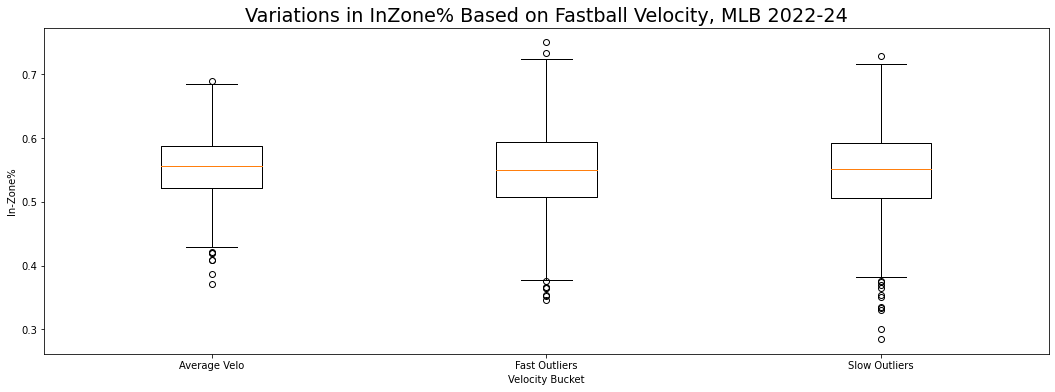

In [20]:
# In Zone Boxplot

fig, ax = plt.subplots(figsize = (18, 6))

font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 16}
plt.rc('font', **font)

ax.boxplot([inZoneAverage, inZoneSlower, inZoneFaster], labels = ['Average Velo', 'Fast Outliers', 'Slow Outliers'])

ax.set_title('Variations in InZone% Based on Fastball Velocity, MLB 2022-24')
ax.set_xlabel('Velocity Bucket')
ax.set_ylabel('In-Zone%')

In [21]:
# Waste Percentage

wasteAverage = commandData[commandData['VeloBucket'] == 'Average']['Waste']
wasteSlower = commandData[commandData['VeloBucket'] == 'Slower']['Waste']
wasteFaster = commandData[commandData['VeloBucket'] == 'Faster']['Waste']

wasteTest = f_oneway(wasteAverage, wasteSlower, wasteFaster)

wasteTest

F_onewayResult(statistic=12.718822118677261, pvalue=3.2001785586864065e-06)

Text(0, 0.5, 'Waste%')

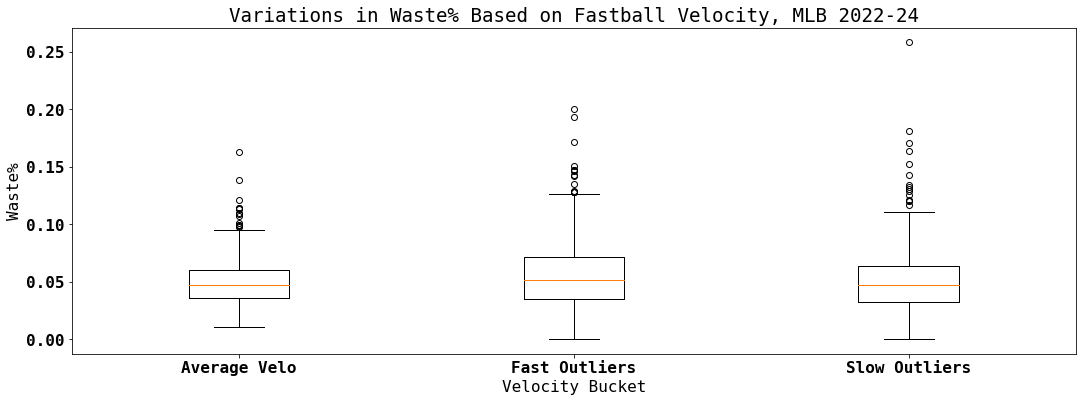

In [22]:
# Waste Boxplot

fig, ax = plt.subplots(figsize = (18, 6))

ax.boxplot([wasteAverage, wasteSlower, wasteFaster], labels = ['Average Velo', 'Fast Outliers', 'Slow Outliers'])

ax.set_title('Variations in Waste% Based on Fastball Velocity, MLB 2022-24')
ax.set_xlabel('Velocity Bucket')
ax.set_ylabel('Waste%')

In [23]:
# Shadow Percentage

shadowAverage = commandData[commandData['VeloBucket'] == 'Average']['Shadow']
shadowSlower = commandData[commandData['VeloBucket'] == 'Slower']['Shadow']
shadowFaster = commandData[commandData['VeloBucket'] == 'Faster']['Shadow']

shadowTest = f_oneway(shadowAverage, shadowSlower, shadowFaster)

shadowTest

F_onewayResult(statistic=6.08946310609967, pvalue=0.0023015790438348583)

Text(0, 0.5, 'Shadow%')

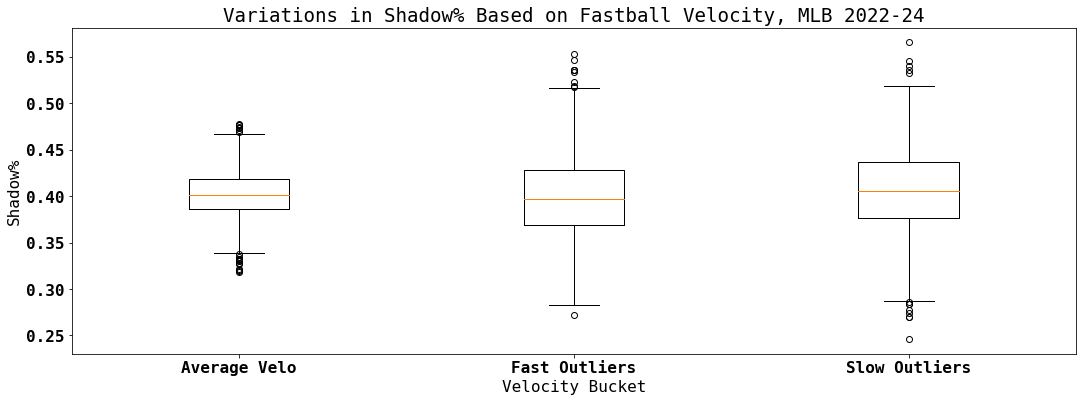

In [24]:
# Shadow Boxplot

fig, ax = plt.subplots(figsize = (18, 6))

ax.boxplot([shadowAverage, shadowSlower, shadowFaster], labels = ['Average Velo', 'Fast Outliers', 'Slow Outliers'])

ax.set_title('Variations in Shadow% Based on Fastball Velocity, MLB 2022-24')
ax.set_xlabel('Velocity Bucket')
ax.set_ylabel('Shadow%')

In [25]:
# Heart Percentage

heartAverage = commandData[commandData['VeloBucket'] == 'Average']['Heart']
heartSlower = commandData[commandData['VeloBucket'] == 'Slower']['Heart']
heartFaster = commandData[commandData['VeloBucket'] == 'Faster']['Heart']

heartTest = f_oneway(heartAverage, heartSlower, heartFaster)

heartTest

F_onewayResult(statistic=4.802881288049776, pvalue=0.008284618207151446)

Text(0, 0.5, 'Heart%')

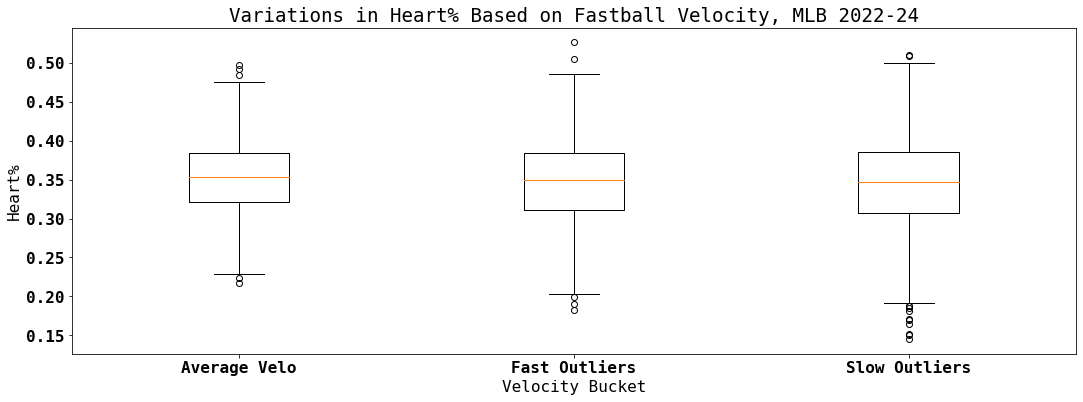

In [26]:
# Heart Boxplot

fig, ax = plt.subplots(figsize = (18, 6))

ax.boxplot([heartAverage, heartSlower, heartFaster], labels = ['Average Velo', 'Fast Outliers', 'Slow Outliers'])

ax.set_title('Variations in Heart% Based on Fastball Velocity, MLB 2022-24')
ax.set_xlabel('Velocity Bucket')
ax.set_ylabel('Heart%')